In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
pd.set_option("display.max_columns",999)

In [2]:
train = pd.read_pickle("train_outdel.pkl")
test = pd.read_pickle("test_outdel.pkl")
df = pd.read_pickle("df_outdel.pkl")

df_outdel_fillmean = pd.read_pickle("df_outdel_fillmean.pkl")
df_outdel_fillmedi = pd.read_pickle("df_outdel_fillmedi.pkl")

In [3]:
numeric_col=[]
categoric_col=[]
tempdf=pd.DataFrame(df.dtypes, columns=['type'])
for i in range(len(df.columns)) :
    if tempdf['type'][i] == 'object' :
        categoric_col.append(tempdf.index[i])
    else :
        numeric_col.append(tempdf.index[i])

In [4]:
df['SalePrice_null'] = df['SalePrice'].isnull()

## For Analysis

In [43]:
def category(df, col, target='SalePrice'):
    """
    - countplot : test vs train
    - columns vs saleprice
    """
    print(col)
    print(df[col].value_counts())
    na = df[col].isnull().sum() / len(df)
    print(f'na is about {round(na,3)}')        
    plt.figure(figsize=(16,6))
    plt.subplot(2,1,1)
    sns.countplot(data=df, x=col, hue='SalePrice_null')
    plt.subplot(2,1,2)
    sns.boxplot(data=df, x=col, y='SalePrice' )
    plt.show()

Alley
Grvl    119
Pave     78
Name: Alley, dtype: int64
na is about 0.932


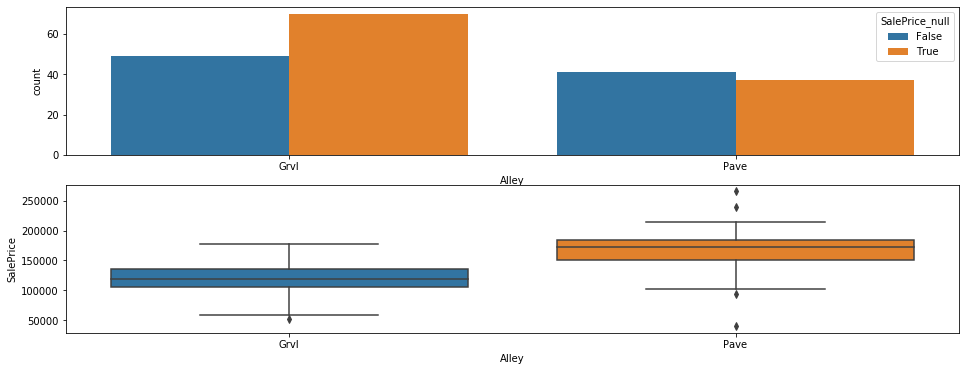

In [45]:
category(df, 'Alley') # categoric_col[42]

## NA

In [5]:
na_df = pd.DataFrame(df[categoric_col].isnull().mean(axis=0), columns=['NA'])

namore70 = []
namore50 = []
namore0 = []
for i in range(len(na_df)):
    if na_df['NA'][i] > 0.7:
        namore70.append(na_df.index[i])
    elif na_df['NA'][i] > 0.5:
        namore50.append(na_df.index[i])
    elif na_df['NA'][i] > 0:
        namore0.append(na_df.index[i])

In [6]:
na_df

,NA
MSZoning,0.001381
Street,0.000000
Alley,0.931975
LotShape,0.000000
LandContour,0.000000
Utilities,0.000691
LotConfig,0.000000
LandSlope,0.000000
Neighborhood,0.000000
Condition1,0.000000


In [7]:
namore70

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

- Alley : 93% NA
- PoolQC : 99.7% NA
- Fence : 80% NA
- MiscFeature : 96%
    - feature들을 지우면 될 것 같다

In [8]:
namore50

[]

In [9]:
namore0

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'SaleType']

- FireplaceQu : 50% NA, 해당 값들은 Fireplace가 없어서 생기는 값으로 생각된다. 따라서 'Missing' 이라고 채운다.
- 나머지는 그 수가 적어서 Frequency가 가장 높은 값으로 imputation 하면 될 것 같다.
- 또는 패키지를 이용해본다 https://github.com/awslabs/datawig
    - 일단 지금은 그냥 Frequency가 가장 높은 값으로 imputation

In [10]:
def impute_na(df_train, df_test, variable):
    # find most frequent category
    most_frequent_category = df_train.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    
    # replace NA
    df_train[variable].fillna(most_frequent_category, inplace=True)
    df_test[variable].fillna(most_frequent_category, inplace=True)

In [11]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('Missing')
test['FireplaceQu'] = test['FireplaceQu'].fillna('Missing')

In [12]:
for i in namore0:
    impute_na(train, test, i)

## Higth cardinality & Low frequency
- frequency가 작은 label들을 'rare'와 같은 label로 묶어준다
- 이후에는 SalePrice와 함께 고려하여 묶어주면 될 것 같다

In [13]:
temp_df = pd.concat([train[categoric_col], test[categoric_col]])

In [14]:
# temp_df.to_pickle('df_fillna(cate).pkl')

In [15]:
temp_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Missing,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [16]:
to_much_freq = []
cate = categoric_col.copy()
for i in categoric_col:
    if (df[i].value_counts()[0] > len(df)*0.8 and df[i].nunique() > 2) or df[i].value_counts()[0] > len(df)*0.95:
        to_much_freq.append(i)

In [17]:
to_much_freq

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

- 위의 feature들은 지우는게 좋을 것 같다

In [18]:
del_col = namore70 + to_much_freq

In [19]:
del_col

['Alley',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [20]:
for i in del_col:
    cate.remove(i)

In [21]:
cate

['MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

In [22]:
below4 = []
notbelow4 = []

for i in cate:
    if df[i].nunique() < 4 : below4.append(i)
    else : notbelow4.append(i)

In [23]:
below4
# 여기는 그냥 진행

['CentralAir', 'GarageFinish']

In [24]:
notbelow4
# 여기는 묶는 과정 실행

['MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageType']

In [151]:
num = []
for i in notbelow4:
    num.append(temp_df[i].nunique())
num

[5, 4, 5, 25, 8, 6, 15, 16, 4, 4, 6, 4, 4, 6, 5, 4, 6, 6]

8개보다 큰 경우 6개로 묶고 나머지는 3개로 묶자

In [156]:
num = []
for i in notbelow4:
    num.append(train[i].nunique())
num

[5, 4, 5, 25, 8, 6, 15, 16, 4, 4, 6, 4, 4, 6, 5, 4, 6, 6]

In [157]:
num = []
for i in notbelow4:
    num.append(test[i].nunique())
num

[5, 4, 5, 25, 7, 6, 13, 15, 4, 4, 6, 4, 4, 6, 5, 4, 6, 6]

In [27]:
notbelow4

['MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageType']

condintion, quality를 평가하는 feature는 그냥 합하지 말고 관련성 있는 label끼리 합쳐야한다

In [28]:
QC_col = ['ExterQual','BsmtQual', 'BsmtExposure', 'HeatingQC']
for i in QC_col:
    notbelow4.remove(i)
# ExterQual : Fa를 TA로 바꾸기
# BsmtQual :  Fa를 TA로 바꾸기
# BsmtExposure : 유지
# HeatingQC : Po를 Fa로 바꾸기

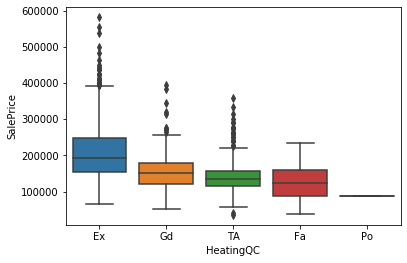

In [44]:
sns.boxplot(data=train, x='HeatingQC', y='SalePrice')

In [45]:
def rare_imputation(df_train, df_test, col) :
    if df_train[col].nunique() > 8:
        rare = temp_df[col].value_counts().index[5:].tolist()
    else:
        rare = temp_df[col].value_counts().index[2:].tolist()
    df_train[col] = np.where(df_train[col].isin(rare), 'rare', df_train[col])
    df_test[col] = np.where(df_test[col].isin(rare), 'rare', df_test[col])

In [46]:
for i in notbelow4:
    rare_imputation(train, test, i)

In [47]:
temp_df = pd.concat([train[categoric_col], test[categoric_col]])
temp_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Missing,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,rare,Gtl,rare,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,rare,Unf,GasA,Ex,Y,SBrkr,TA,Typ,rare,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,rare,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,rare,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,rare,None,TA,TA,rare,TA,Gd,No,rare,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,rare,Gtl,rare,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,rare,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


- ExterQual : Fa를 TA로 바꾸기
- BsmtQual :  Fa를 TA로 바꾸기
- BsmtExposure : 유지
- HeatingQC : Po를 Fa로 바꾸기

In [48]:
temp_df['ExterQual'] = np.where(temp_df['ExterQual'] == 'Fa', 'TA', temp_df['ExterQual'] )
temp_df['BsmtQual'] = np.where(temp_df['BsmtQual'] == 'Fa', 'TA', temp_df['BsmtQual'] )
temp_df['HeatingQC'] = np.where(temp_df['HeatingQC'] == 'Po', 'Fa', temp_df['HeatingQC'] )

In [49]:
df_outdel_fillmean.shape

(2896, 36)

In [50]:
temp_df.shape

(2896, 43)

In [51]:
temp_df.to_pickle('df_FE(cate).pkl')